# Whole-brain embeddings of all mouse connectomes in a low-dimensional space

This notebook replicates Figure 5 from _Multiscale Comparative Connectomcis_.

![Fig5](figures/5_whole_brain_embedding.jpg)

In [1]:
%load_ext nb_black
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from graspologic.embed import ClassicalMDS, OmnibusEmbed
from graspologic.datasets import load_mice

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
ventricles = [147, 151, 160]
ventricles += [roi + 166 for roi in ventricles]
ventricles = np.array(ventricles)

def mask_rois(graphs, rois=ventricles):
    """Remove all connections to and from specified ROIs."""
    graphs = np.delete(graphs, ventricles, axis=1)
    graphs = np.delete(graphs, ventricles, axis=2)
    return graphs

<IPython.core.display.Javascript object>

In [4]:
# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
graphs = mask_rois(graphs)

# Sort the connectomes and genotype labels so BTBR is first
label_indices = np.argsort(mice.labels).reshape(4, 8)
label_indices = label_indices[[1, 0, 2, 3]].reshape(-1)

labels = mice.labels[label_indices]
graphs = graphs[label_indices]

<IPython.core.display.Javascript object>

First, `omni` is used to map each vertex in each connectome to a $d$-dimensional vector.
That is, ever graph is mapped to a $n \times d$ matrix, where $n=332$ is the number of vertices in each connectome.

Next, classical multidimensinal scaling (`cMDS`) is used to further embed each connectome representation in a 2-dimensional space.
This is accomplished via an eigendecomposition of a the dissimilarity matrix constructed from pairwise dissimilarity of each connectome embedding.

In [5]:
# Jointly embed graphs using OMNI
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
print(f"Omnibus embedding shape is {omni_embedding.shape}")

# Further reduce dimensionality with cMDS
cmds = ClassicalMDS(2)
cmds_embedding = cmds.fit_transform(omni_embedding)
print(f"cMDS embedding shape is {cmds_embedding.shape}")

Omnibus embedding shape is (32, 326, 5)
cMDS embedding shape is (32, 2)


<IPython.core.display.Javascript object>

In [6]:
# Normalize the dissimilarity matrix calculated by cMDS
dis_mat = cmds.dissimilarity_matrix_
normalized_dissimilarity_matrix = dis_mat / np.max(dis_mat)

<IPython.core.display.Javascript object>

Visualize the dissimilarity matrix.

In [7]:
%%R -i normalized_dissimilarity_matrix

# Read data and make genotype labels
genotype <- c(rep("BTBR", 8), rep("B6", 8), rep("CAST", 8), rep("DBA2", 8))
genotype <- factor(genotype, levels = unique(genotype))
dissimilarity <- as.matrix(normalized_dissimilarity_matrix)
colnames(dissimilarity) <- genotype
rownames(dissimilarity) <- genotype

<IPython.core.display.Javascript object>

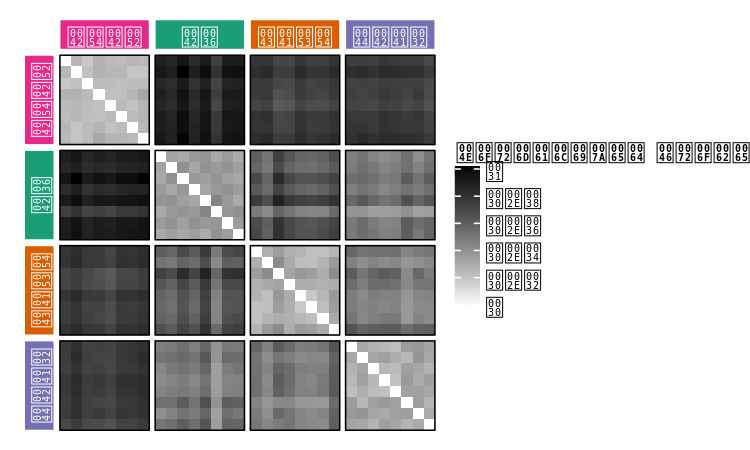

<IPython.core.display.Javascript object>

In [8]:
%%R -w 5 -h 3 --units in -r 150

suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))

# Set plot dimensions
width <- unit(2.5, "in")

# Make the colorbar
col_fun <- colorRamp2(c(0, 1), c('white', 'black'), transparency = 0)
colorbar <- Legend(col_fun = col_fun, 
                   title = "Normalized Frobenius Norm", 
                   legend_width = width, 
                   direction = "horizontal")

# Make heatmap
ha = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = c("#e7298a", "#1b9e77", "#d95f02", "#7570b3"), col = 0),
                                        labels = unique(genotype),
                                        labels_gp = gpar(col = "white", fontsize = 10)),
                       height = unit(5, "mm"))
ra = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#e7298a", "#1b9e77", "#d95f02", "#7570b3"), col = 0),
                                    labels = unique(genotype),
                                    labels_gp = gpar(col = "white", fontsize = 10)),
                   width = unit(5, "mm"))
ht <- Heatmap(
  matrix = dissimilarity,
  name = "Normalized Frobenius Norm",
  col = col_fun,
  border = TRUE,
  column_title = NULL,
  cluster_columns = FALSE, cluster_column_slices = FALSE, show_column_names = FALSE,
  cluster_rows = FALSE, cluster_row_slices = FALSE, show_row_names = FALSE, row_title = NULL,
  column_split = genotype, row_split = genotype,
  top_annotation = ha,
  left_annotation = ra,
  width = width, height = width
)
draw(ht, show_heatmap_legend = TRUE)

Plot 2D embedding of all graphs.
Note how distict the BTBR mice are from all others.

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



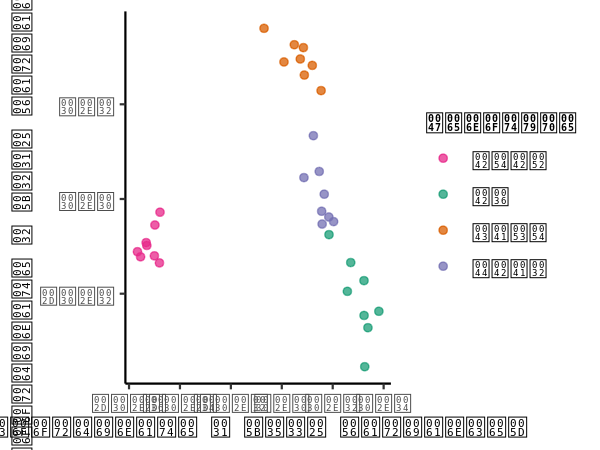

<IPython.core.display.Javascript object>

In [9]:
%%R -w 4 -h 3 --units in -r 150

library(ggplot2)
library(grid)

# Embed using cMDS with BTBR
fit <- cmdscale(dissimilarity, k = 2, eig = TRUE)
w.btbr <- as.data.frame(fit$points)
w.btbr$genotype <- genotype
w.var.1 <- fit$eig[1] / sum(fit$eig) * 100
w.var.2 <- fit$eig[2] / sum(fit$eig) * 100

ggplot(w.btbr, aes(x=V1, y=V2, color=genotype)) + 
  geom_point(alpha=0.75) + 
  theme_classic() +
  scale_color_manual(values=c("#e7298a", "#1b9e77", "#d95f02", "#7570b3")) +
  xlab(sprintf("Coordinate 1 [%.0f%% Variance]", w.var.1)) +
  ylab(sprintf("Coordinate 2 [%.0f%% Variance]", w.var.2)) +
  guides(color=guide_legend(title="Genotype", title.theme = element_text(face = "bold", size = 10), ncol=1))

Plot 2D embedding of all graphs except for BTBR.
Note that even the control strains are highly separable.

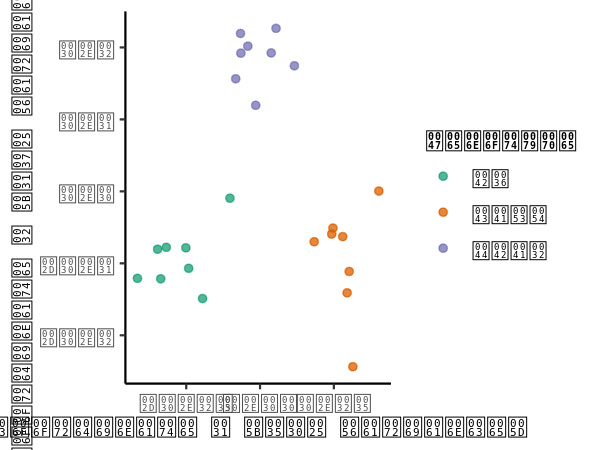

<IPython.core.display.Javascript object>

In [10]:
%%R -w 4 -h 3 --units in -r 150

# Embed using cMDS without BTBR
wo.btbr <- dissimilarity[-which(rownames(dissimilarity) == "BTBR"), -which(colnames(dissimilarity) == "BTBR")]
fit <- cmdscale(wo.btbr, k = 2, eig = TRUE)
wo.btbr <- as.data.frame(fit$points)
wo.btbr$genotype <- genotype[-which(genotype == "BTBR")]
wo.var.1 <- fit$eig[1] / sum(fit$eig) * 100
wo.var.2 <- fit$eig[2] / sum(fit$eig) * 100

ggplot(wo.btbr, aes(x=V1, y=V2, color=genotype)) + 
  geom_point(alpha=0.75) + 
  theme_classic() +
  scale_color_manual(values=c("#1b9e77", "#d95f02", "#7570b3")) +
  xlab(sprintf("Coordinate 1 [%.0f%% Variance]", wo.var.1)) +
  ylab(sprintf("Coordinate 2 [%.0f%% Variance]", wo.var.2)) +
  guides(color=guide_legend(title="Genotype", title.theme = element_text(face = "bold", size = 10), ncol=1))

## Interstrain versus intrastrain dissimilarity

Quantify the dissimilarity amongst different groups of mice.

In [11]:
# Block matrices for building masks of the dissimilarity matrix
a = np.ones((8, 8))
b = np.zeros((8, 8))

<IPython.core.display.Javascript object>

In [12]:
# All strains: interstrain versus intrastrain
mask = np.block([[a, b, b, b], [b, a, b, b], [b, b, a, b], [b, b, b, a]])
mask = mask == 1

avg_intra_dis = np.mean(normalized_dissimilarity_matrix[mask])
print(f"Average intrastrain dissimilarity is {avg_intra_dis:.1%}.")

avg_inter_dis = np.mean(normalized_dissimilarity_matrix[~mask])
print(f"Average interstrain dissimilarity is {avg_inter_dis:.1%}.")

Average intrastrain dissimilarity is 26.3%.
Average interstrain dissimilarity is 66.6%.


<IPython.core.display.Javascript object>

In [13]:
# Interstrain dissimilarity of BTBR versus controls
mask = np.block([[b, a, a, a], [b, b, b, b], [b, b, b, b], [b, b, b, b]]) == 1
avg_btbr_dis = np.mean(normalized_dissimilarity_matrix[mask])
print(f"BTBR is on average {avg_btbr_dis:.1%} dissimilar to B6, CAST, and DBA2.")

# Interstrain dissimilarity between control strains
mask = np.block([[b, b, b, b], [b, b, a, a], [b, a, b, a], [b, a, a, b]]) == 1
avg_nonbtbr_dis = np.mean(normalized_dissimilarity_matrix[mask])
print(f"Average dissimilarity between B6, CAST, and DBA2 is {avg_nonbtbr_dis:.1%}.")

BTBR is on average 79.3% dissimilar to B6, CAST, and DBA2.
Average dissimilarity between B6, CAST, and DBA2 is 54.0%.


<IPython.core.display.Javascript object>